# Forecasting multiple independent time series: Global forecasting
Conda environment: `time-series`   
27 May 2024

In [1]:
import os
os.chdir(path="/Users/razielar/Documents/git_rep/personal_repos/forecasting_with_ml/")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom

from src.multipleseries_forecasting import create_predictors

In [3]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [4]:
# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### 1.1) Data Preprocessing

In [5]:
# We are going to use only 1 store == 2 from the 10 input stores
selected_store = 2
# All skus
selected_items = data["item"].unique()

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].reset_index(drop=True).copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data

,date,store,item,sales
0,2013-01-01,2,1,12
1,2013-01-02,2,1,16
2,2013-01-03,2,1,16
3,2013-01-04,2,1,20
4,2013-01-05,2,1,16
...,...,...,...,...
91295,2017-12-27,2,50,79
91296,2017-12-28,2,50,68
91297,2017-12-29,2,50,67
91298,2017-12-30,2,50,79


In [6]:
# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")
data

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [7]:
# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily. This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [8]:
# Check if any missing values introduced
data.isnull().sum().any()

False

### 1.2) EDA

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_21632/503142491.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


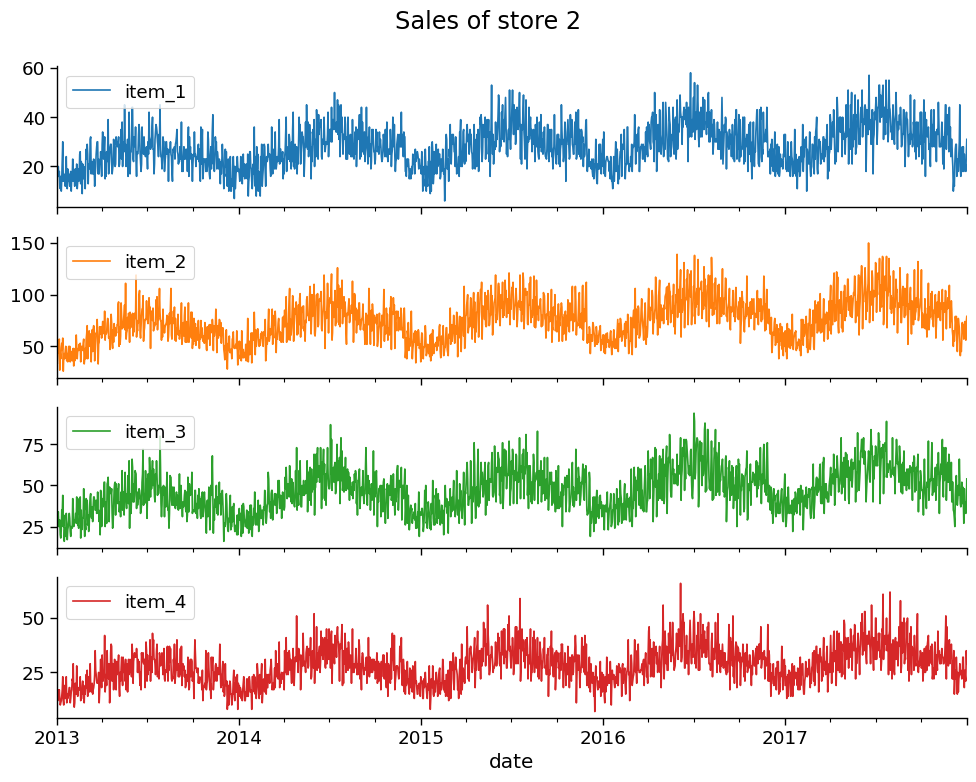

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title= f"Sales of store {selected_store}",
    ax=ax,
)

fig.tight_layout()

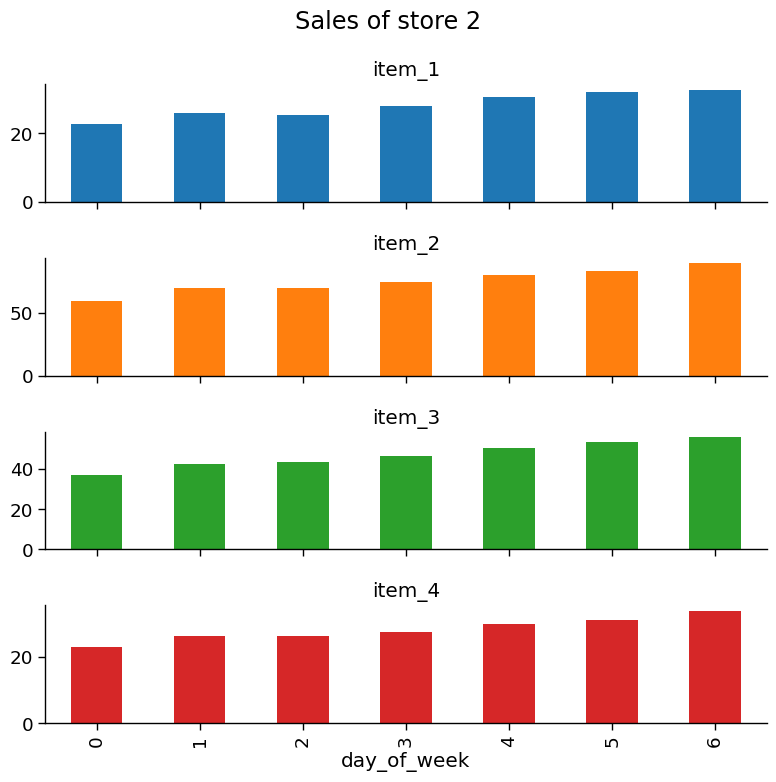

In [10]:
# Quick  plot to check for weekly seasonality
(
    data.assign(day_of_week=lambda x: data.index.weekday).groupby("day_of_week").mean()
).iloc[:, :4].plot(
    legend=False,
    subplots=True,
    sharex=True,
    title=f"Sales of store {selected_store}",
    kind="bar",
    figsize=(8,8)
)

plt.tight_layout()

In [11]:
# We're going to add the day of week to se as an exogenous feature
data["day_of_week"] = data.index.weekday
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000,1
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000,2
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000,3
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000,4
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000,2
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000,3
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000,4


## 2) Global Forecasting

In [12]:
name_predictors = [f"lag_{i}" for i in range(1, 8)] + [
    "mean_7",
    "std_7",
    "mean_30",
    "std_30",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'mean_7',
 'std_7',
 'mean_30',
 'std_30']

### 2.1) Exogenous features

In [13]:
# Forecast horizon: Number of steps to predict
HORIZON = 14

# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=HORIZON + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday
future_exog

,day_of_week
2018-01-01,0
2018-01-02,1
2018-01-03,2
2018-01-04,3
2018-01-05,4
2018-01-06,5
2018-01-07,6
2018-01-08,0
2018-01-09,1
2018-01-10,2


### 2.2) Linear-models: Ridge

In [14]:
# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterAutoregMultiSeries(
#                  regressor        = Ridge(alpha=1),
#                  lags             = 7
#                  transformer_series    = StandardScaler(),
#                  transformer_exog = StandardScaler(),
#              )

# Create forecaster
forecaster = ForecasterAutoregMultiSeriesCustom(
    regressor=Ridge(alpha=1),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=30,  # Largest window size needed by `create_predictors`
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

forecaster.fit(
    series=data[target_cols],  # Dataframe of target time series at train time
    exog=data[exog_cols],  # Dataframe of exogenous variables at train time
)

forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: Ridge(alpha=1) 
Predictors created with function: create_predictors 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 30 
Series levels (names): ['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49', 'item_50'] 
Series weights: None 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['day_of_week'] 
Training range: [Timestamp(

### 2.3) QC

In [15]:
# QC: Let's see which are the X and y inputs before training
X_train, y_train, y_index, y_train_index = forecaster.create_train_X_y(
    series=data[target_cols], exog=data[exog_cols]
)
display(X_train.columns)
display(X_train.head(), y_train.head())

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'mean_7',
       'std_7', 'mean_30', 'std_30', 'day_of_week', 'item_1', 'item_10',
       'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16',
       'item_17', 'item_18', 'item_19', 'item_2', 'item_20', 'item_21',
       'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27',
       'item_28', 'item_29', 'item_3', 'item_30', 'item_31', 'item_32',
       'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38',
       'item_39', 'item_4', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_5', 'item_50', 'item_6', 'item_7', 'item_8', 'item_9'],
      dtype='object')

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,mean_30,std_30,day_of_week,item_1,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_2,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_3,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_4,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.2875,-1.6332,-1.6002,0.2935,-1.4411,0.4928,-0.0008,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.2875,-1.5673,0.3008,-1.4258,0.4865,0.4993,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.5838,0.2879,-1.4258,0.4865,0.9995,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,-0.5961,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.4356,0.4472,-1.3989,0.5088,1.4997,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,-1.6332,-0.5961,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.4027,0.4222,-1.4219,0.5032,-1.5013,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


0   -1.4027
1   -1.4027
2   -0.5961
3   -1.6332
4   -1.1723
Name: y, dtype: float64

In [16]:
display(X_train.tail(), y_train.tail())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,mean_30,std_30,day_of_week,item_1,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_2,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_3,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_4,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
89795,-1.5138,-1.1640,0.1914,0.2351,-0.1584,-0.4207,-0.7705,-0.5144,0.6190,-0.5096,0.6702,-0.5010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
89796,-0.2458,-1.5138,-1.1640,0.1914,0.2351,-0.1584,-0.4207,-0.4394,0.6152,-0.5227,0.6610,-0.0008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
89797,-0.7268,-0.2458,-1.5138,-1.1640,0.1914,0.2351,-0.1584,-0.4832,0.6231,-0.5606,0.6386,0.4993,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
89798,-0.7705,-0.7268,-0.2458,-1.5138,-1.1640,0.1914,0.2351,-0.5706,0.6143,-0.6014,0.6110,0.9995,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
89799,-0.2458,-0.7705,-0.7268,-0.2458,-1.5138,-1.1640,0.1914,-0.6393,0.5431,-0.6437,0.5366,1.4997,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


89795   -0.2458
89796   -0.7268
89797   -0.7705
89798   -0.2458
89799   -0.5081
Name: y, dtype: float64

In [17]:
# Forecast for all items
forecast = forecaster.predict(
    steps=HORIZON, 
    exog=future_exog, 
    levels=None)

forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,16.0796,53.3625,29.8820,19.5839,16.3286,50.1650,52.4682,73.4969,42.4948,61.3933,61.8558,62.2552,75.3576,49.6731,77.5564,17.8058,24.8513,71.6999,33.5057,39.4714,35.1367,69.8232,25.4823,54.2228,74.1791,42.2683,18.7285,80.1758,60.7596,35.1185,51.9563,41.1847,57.6808,20.9577,55.7717,71.9676,24.1794,73.8461,37.1327,26.0804,16.7021,34.1094,46.2365,24.2602,78.6123,52.5790,19.6955,41.9714,25.4179,54.7386
2018-01-02,18.7994,58.6138,35.0722,21.2305,16.9513,53.4309,56.6442,82.4515,48.2193,69.6781,69.5087,69.2272,82.6933,54.5109,83.7688,20.1168,28.9801,77.9422,36.5030,42.8126,37.3477,79.1758,28.8277,60.1788,82.7625,46.9310,20.5039,87.3883,67.0487,36.8945,56.8247,45.5376,64.4017,22.0187,60.1153,79.4284,27.2614,82.5064,39.8350,28.2031,18.4822,37.7319,50.5706,26.1113,87.2210,57.7759,21.6388,45.7212,29.2572,59.0106
2018-01-03,19.3088,61.4288,35.5072,22.9092,18.4159,57.0208,60.1856,85.5512,51.0212,72.4653,72.9945,71.5882,85.6353,58.3714,89.5802,21.8947,29.6219,82.3682,38.8959,46.1145,38.9822,83.5494,30.2514,63.6416,87.7994,49.8876,21.8477,91.0367,69.5767,40.1727,60.2102,47.7185,65.8265,23.1320,63.3884,83.1592,28.3207,87.1149,41.4796,29.7782,20.2061,39.8584,52.6105,27.8475,90.7498,61.3388,22.1791,48.8555,29.8931,64.2087
2018-01-04,21.3865,64.8420,38.4651,24.4021,19.7354,61.5402,64.5646,92.2555,55.2464,78.5587,78.9917,76.8919,93.6990,63.1933,94.2495,23.5312,32.9666,88.0576,41.9385,49.1813,42.5572,89.0468,32.6413,68.7214,92.2724,53.0761,24.2846,99.3065,76.2217,43.1749,63.2506,51.5112,72.1430,25.2971,68.0114,88.9585,30.7158,93.5457,46.0753,32.3052,21.8827,43.3996,57.5291,30.0787,96.2153,66.0103,24.0531,52.3419,32.2746,67.9619
2018-01-05,23.3760,68.6748,41.3333,26.3140,21.9447,66.3796,68.5270,98.7769,58.7004,84.2686,85.6203,82.1884,100.4584,67.8140,102.2322,26.6574,35.7639,94.3618,46.0385,53.1942,46.4511,96.1241,35.0722,74.8287,99.0374,58.5585,26.0373,104.3372,82.5526,45.9490,69.1126,54.2837,76.6758,27.9221,74.6828,94.9300,32.7434,100.3358,49.3310,34.8165,24.1824,46.7132,61.0410,32.7500,102.1199,71.3700,26.4401,58.3126,35.1090,73.3085
2018-01-06,26.1047,74.9676,45.1719,29.3725,23.3797,70.7468,73.7678,104.8561,64.0388,90.5175,91.0610,89.9553,106.5645,70.5580,109.5964,28.8315,39.7467,100.9155,49.0485,57.3138,49.4104,103.0663,37.6820,80.1787,106.5702,60.9355,28.8730,112.7908,87.2443,49.8858,73.2349,58.7595,85.0585,30.4243,80.5890,101.4721,34.6392,105.3573,53.6134,37.0891,26.5236,49.1520,65.9627,35.0482,110.0244,75.4913,27.7816,62.9049,37.7081,79.8532
2018-01-07,28.7767,80.3827,50.4153,30.9986,25.7014,75.9741,79.1867,112.6290,69.7680,99.3050,98.2348,94.7364,114.4829,77.9055,117.7465,31.8811,43.9201,109.1315,53.2150,61.4656,52.3394,110.9393,40.9101,86.8463,114.6158,66.1456,30.9507,119.2061,93.8645,53.4643,79.8083,62.7865,91.3323,33.7887,85.1950,109.0627,38.0948,114.0548,57.1067,40.7092,29.2041,52.8078,70.2511,37.9008,118.3115,81.3787,30.2975,67.7063,41.7517,85.7026
2018-01-08,16.7048,52.8847,31.5083,19.5104,15.5559,50.3494,52.3547,75.5082,44.3429,63.3301,63.8932,63.4218,76.1257,50.7804,78.9067,18.7712,26.3808,72.8344,34.2499,40.4159,34.2731,72.0252,25.8811,57.1577,75.6287,42.8647,19.0666,80.7101,61.5690,34.3467,53.3208,41.6348,59.5660,21.0337,56.4167,74.1424,23.9534,76.3494,36.8245,25.0056,17.2974,34.5143,47.0974,24.3846,81.3156,53.8879,19.2830,43.5717,26.1636,56.0411
2018-01-09,19.0806,58.2340,35.3138,21.7920,17.4930,55.8395,57.6914,82.8352,49.3950,70.2222,70.5255,69.8250,83.7675,56.2803,86.7561,21.4433,29.8616,80.3726,38.1184,44.9557,38.1082,79.4340,28.8863,63.3226,83.2449,47.4158,21.4372,88.5092,67.8523,38.4026,58.8930,45.8589,66.1035,23.5803,62.3345,81.3

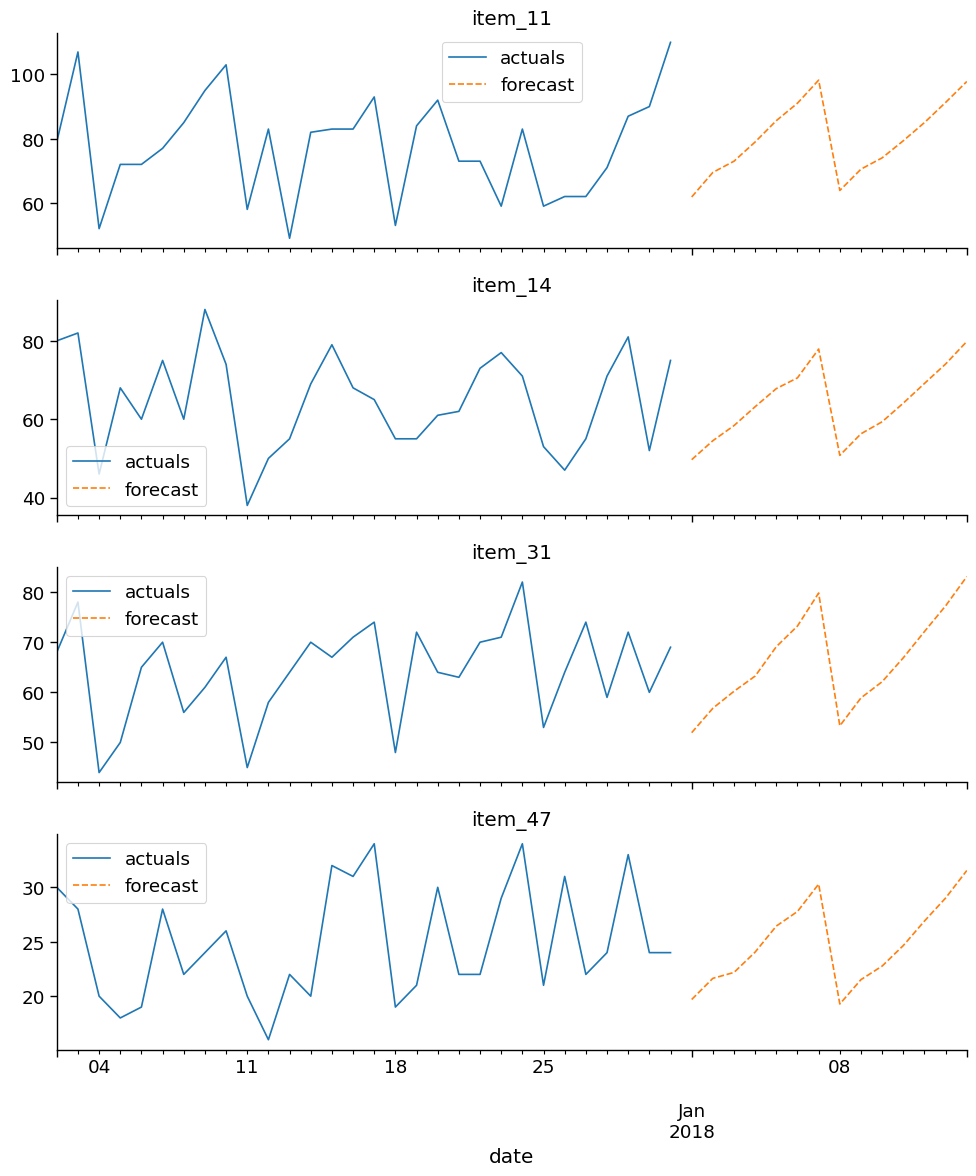

In [18]:
# Select a random subsample of timeseries
num_timeseries = 4
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting Forecast
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [19]:
# Interval forecasts for item_1 and item_2
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html
forecast_intervals = forecaster.predict_interval(
    steps=HORIZON, 
    exog=future_exog, 
    levels=["item_1", "item_2"],
    interval= [5, 95]
)
forecast_intervals.head(3)

,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2018-01-01,16.0796,6.1623,26.1464,53.3625,37.9022,70.2188
2018-01-02,18.7994,9.5320,29.1624,58.6138,42.8895,76.3114
2018-01-03,19.3088,10.0467,28.8566,61.4288,45.7222,79.4825


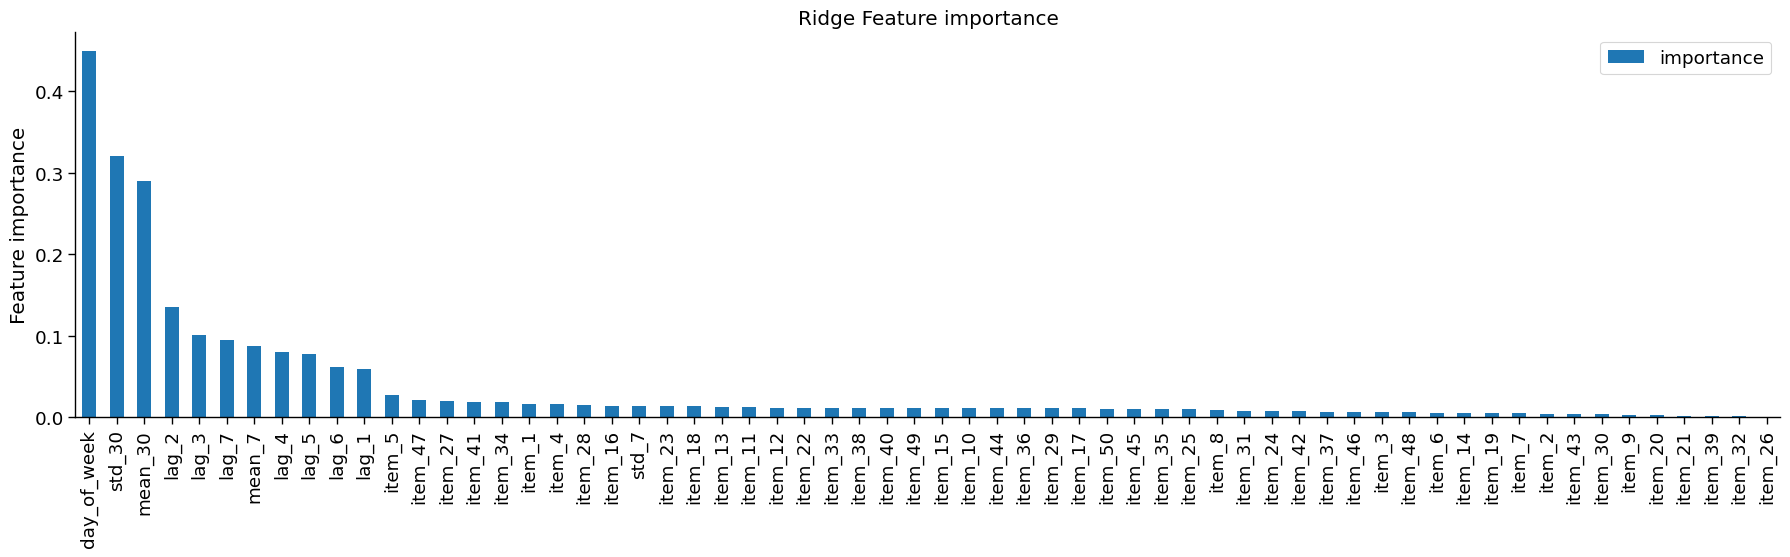

In [20]:
(
    forecaster
    .get_feature_importances()
    .assign(importance = lambda x: abs(x["importance"]))
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .plot(kind="bar")
)

plt.title("Ridge Feature importance")
plt.ylabel("Feature importance")
plt.xlabel("")
plt.show()

## 3) Tree-model: Random Forest

In [21]:
# Create forecaster
forecaster = ForecasterAutoregMultiSeriesCustom(
    regressor=RandomForestRegressor(),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=30,  # Largest window size needed by `create_predictors`
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

forecaster.fit(
    series=data[target_cols],  # Dataframe of target time series at train time
    exog=data[exog_cols],  # Dataframe of exogenous variables at train time
)

forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: RandomForestRegressor() 
Predictors created with function: create_predictors 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 30 
Series levels (names): ['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49', 'item_50'] 
Series weights: None 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['day_of_week'] 
Training range: [T

In [22]:
# Forecast for all items
forecast = forecaster.predict(
    steps=HORIZON, 
    exog=future_exog, 
    levels=None)

forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,17.7908,50.6772,32.3885,18.5142,16.8475,49.6047,50.3689,71.3245,43.4004,65.1413,60.0873,59.6690,75.6078,53.9209,76.6272,18.4284,25.4854,72.3652,32.2933,39.0405,30.6333,77.4352,25.4581,51.4377,72.1743,42.9442,18.7034,80.0724,61.7972,33.3822,52.9505,41.1652,59.5059,23.9095,55.7261,76.0297,26.1766,73.6190,34.9444,26.0525,16.8054,34.5224,47.7238,21.2949,78.4147,50.9235,18.4327,41.9885,27.2940,55.0450
2018-01-02,21.4154,61.7596,37.9548,22.7477,19.2860,59.6735,60.8089,81.1222,56.7930,75.4608,73.3193,72.0647,88.5788,64.5866,94.2782,24.6170,30.1540,87.0085,39.2573,48.6604,37.8724,83.6720,29.7734,61.8670,86.2801,52.9488,23.4779,91.0995,72.8138,39.9160,59.9031,48.2180,68.4192,23.6941,69.3590,78.4067,28.6417,85.6401,42.6067,29.6381,20.1674,41.6869,52.8108,26.8012,88.5114,60.1832,22.5009,47.4940,31.5373,65.9004
2018-01-03,18.9296,59.3381,36.2135,23.2814,18.6540,59.8993,60.5972,81.5173,50.8406,75.4611,76.9720,71.2554,88.7778,61.1738,96.1175,23.2794,30.3906,85.1452,41.0740,49.1917,40.2630,85.9185,29.0726,63.2761,84.6455,49.6170,22.1340,91.2136,74.5639,41.7439,62.4379,49.7259,68.1609,23.3347,68.8821,76.7035,27.5105,86.8258,42.6522,30.6823,20.8163,41.0260,51.4601,26.8266,91.8170,59.0150,22.1039,51.3009,30.0103,66.2833
2018-01-04,21.6288,64.2456,37.5711,25.2534,20.2110,61.1586,65.3506,94.1609,56.4454,86.2164,85.5039,76.8880,93.3025,67.4869,93.7972,26.8514,35.7030,88.4341,40.3053,47.4696,43.3880,97.9932,31.5339,67.8767,95.1072,55.8466,23.2347,103.2828,78.3918,43.2470,67.6210,49.8517,71.9670,22.1856,75.1464,86.2652,30.5857,90.8803,46.8244,34.6046,21.4023,44.4502,54.3634,29.8327,94.5320,66.4571,23.5649,52.4884,35.4253,66.8105
2018-01-05,25.2232,69.2239,41.5326,27.1516,22.3967,66.8850,68.5503,97.9616,58.8459,87.9415,86.6710,81.0206,100.5791,74.3274,104.3381,26.8518,37.1873,92.1480,45.4258,52.0397,47.9743,99.9417,35.9147,74.5234,99.5032,60.0826,26.6045,104.1615,82.7605,43.7674,69.6133,55.7464,77.0846,26.3126,77.3249,94.1912,35.4232,95.9209,48.1321,35.8637,24.8610,49.9081,60.1099,31.1669,99.0202,69.3963,26.9863,53.9374,36.1395,77.3472
2018-01-06,26.6045,73.6268,46.8503,30.6205,23.7768,72.6640,71.9624,100.3941,63.5623,92.8595,92.7850,87.6159,103.2857,74.9311,108.2196,28.1393,40.1848,99.8010,48.6072,53.9359,50.0400,106.6600,35.8302,76.1478,104.8682,60.8012,27.5943,108.4743,85.9008,49.0963,71.5288,60.0801,80.7197,28.9431,84.2323,98.7269,35.6299,103.0274,54.3652,36.4666,27.1604,50.3800,63.1375,33.3305,105.2379,74.5422,28.3420,61.2431,39.6471,81.3937
2018-01-07,29.4682,75.2762,50.4256,30.4002,24.4469,73.8843,74.2494,108.8829,70.5243,100.0712,98.3434,88.1452,110.1535,77.4668,112.4084,30.0471,43.1624,106.3924,49.5719,56.7117,52.0878,110.3048,37.1247,79.0098,112.9704,66.3303,28.1603,112.4053,93.0990,50.1400,74.9878,62.7340,86.9807,30.6060,83.0073,98.8498,37.0443,109.2135,58.2443,39.0912,29.7657,54.7410,64.8512,35.8065,112.0177,74.8000,27.7723,63.1059,41.0444,82.4165
2018-01-08,18.8067,52.0711,32.7765,19.2314,15.2628,50.8305,51.7503,71.9914,45.8477,66.6929,63.6651,61.4385,77.9557,52.4489,80.2436,20.2642,26.2441,70.2123,32.3617,38.8935,35.2466,75.8133,26.1391,52.3354,76.0372,44.4153,19.4913,80.2883,63.6931,32.0582,51.6409,41.6667,58.5988,19.9834,60.7606,69.2328,24.8923,73.0157,36.6371,25.6903,18.1311,35.7371,46.4286,22.8841,79.4988,49.8250,18.7895,40.3880,26.8210,55.4333
2018-01-09,21.2945,59.4828,36.4787,24.2158,18.5891,61.1627,60.3646,86.5275,51.7320,78.5377,74.6440,72.6491,88.3104,61.5116,90.0317,23.9939,32.4730,84.9979,40.3999,51.4463,40.9622,84.8852,28.7254,65.7030,89.3421,51.6001,22.1631,90.4679,73.5192,41.8082,62.1181,49.6180,70.9205,23.3764,67.8127,78.6759

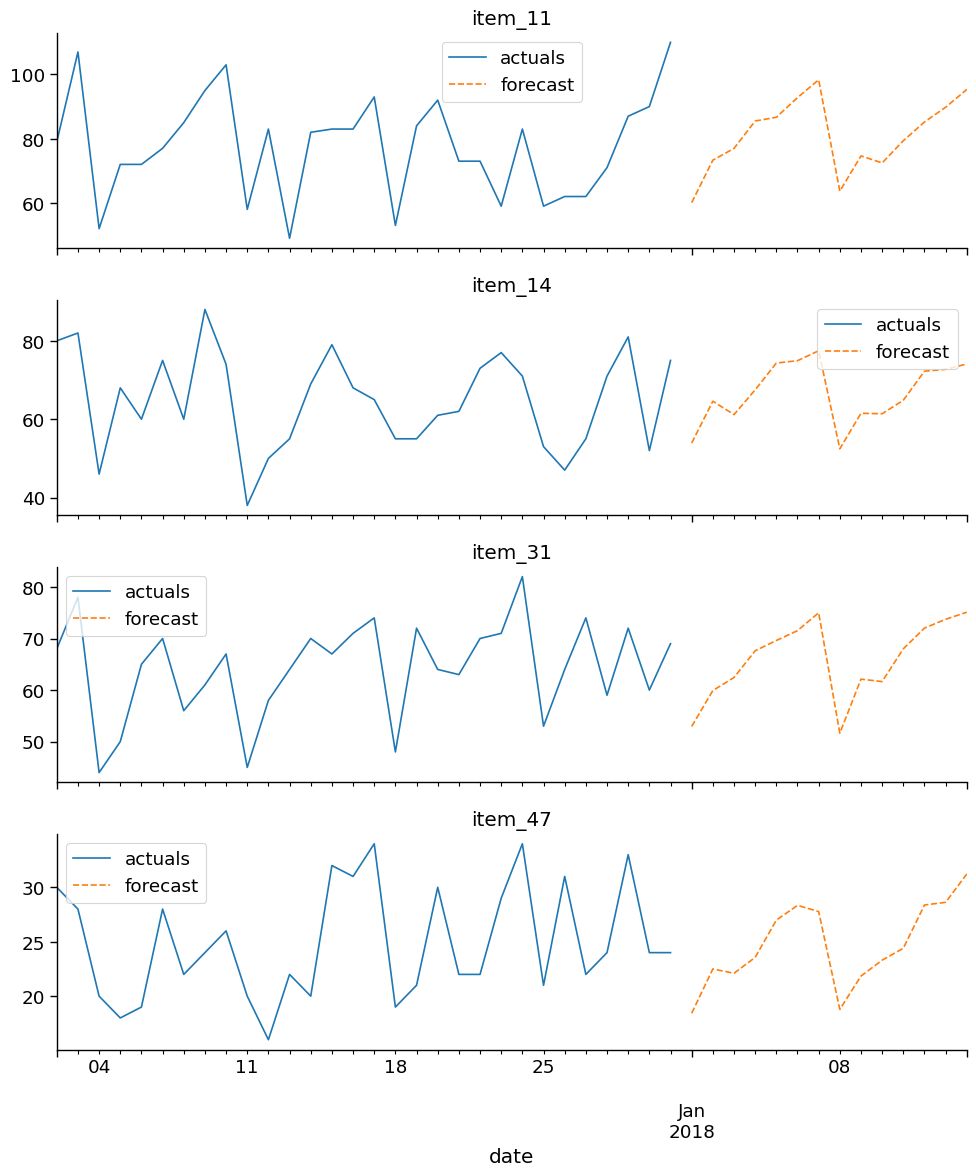

In [23]:
# Select a random subsample of timeseries
num_timeseries = 4
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting Forecast
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [24]:
# Interval forecasts for item_1 and item_2
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html
forecast_intervals = forecaster.predict_interval(
    steps=HORIZON, 
    exog=future_exog, 
    levels=["item_1", "item_2"],
    interval= [5, 95]
)
forecast_intervals.head(3)

,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2018-01-01,17.7908,14.2454,21.4444,50.6772,44.9215,56.9145
2018-01-02,21.4154,17.8447,25.0977,61.7596,56.0592,67.6962
2018-01-03,18.9296,16.0024,22.8813,59.3381,54.0040,67.2498


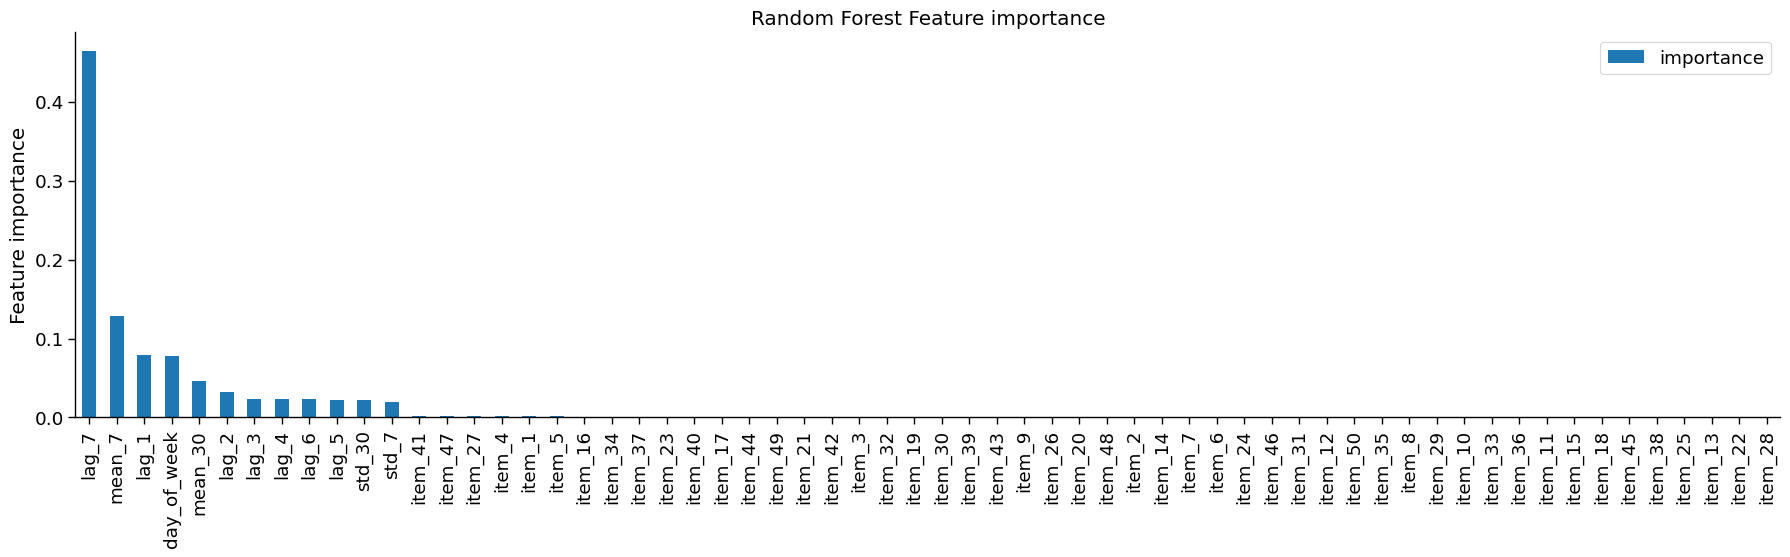

In [25]:
(
    forecaster
    .get_feature_importances()
    .assign(importance = lambda x: abs(x["importance"]))
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .plot(kind="bar")
)

plt.title("Random Forest Feature importance")
plt.ylabel("Feature importance")
plt.xlabel("")
plt.show()